## Libraries

In [1]:
!pip install pmdarima -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# Generic
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc, warnings, re
warnings.filterwarnings("ignore")

# Plotting
import matplotlib.pyplot as plt
import plotly.express as px

from tabulate import tabulate

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt

from sklearn.linear_model import LinearRegression
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

# Arima Model
import pmdarima as pm

# Prophet
from fbprophet import Prophet

# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

## Data

In [3]:
# Data Load
df = pd.read_csv(url,index_col='Date', header='infer', parse_dates=True, infer_datetime_format=True)

# Dropping Unwanted Columns
unwanted_cols = ['Country','State','Location']
df.drop(unwanted_cols, axis=1, inplace=True)

# Renaming Columns
df.rename(columns={"Pure Gold (24 k)": "Pure_Gold_24k",
                   "Standard Gold (22 K)": "Std_Gold_22k",
                  },inplace=True)

# Total Records
print("Total Records: ", df.shape[0])

# Inspect
df.head()

Total Records:  4954


,Pure_Gold_24k,Std_Gold_22k
Date,,
2006-01-02,768.0,711.0
2006-01-03,770.5,713.0
2006-01-04,784.5,726.0
2006-01-05,782.5,725.0
2006-01-06,776.0,719.0


## Data Scaling

In [4]:
# Scaling Data
cols = df.columns
idx = df.index
scaler = MinMaxScaler(feature_range=(0,1))

df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=cols, index=idx)

## Visualisation

In [5]:
# Visualisation

fig = px.line(df, x=df.index, y=df.columns,
              title='Gold Prices in Chennai (2006-2020)')

fig.update_xaxes(tickangle=45)
fig.show()

In [6]:
fig = px.scatter(df, x=df.index, y=df.columns, marginal_x="box", marginal_y="violin", title="Chennai Gold Rate Marginal Distribution Plot")
fig.show()

## Linear Regression

The most basic machine learning algorithm that can be implemented on this data is linear regression. The linear regression model returns an equation that determines the relationship between the independent variables and the dependent variable.

For our Gold Rate dataset, we do not have a set of independent variables. We have only the dates instead. Let us use the date column to extract features like – day, month, year,  mon/fri etc. and then fit a linear regression model.

In [7]:
# Creating a seperate dataframe
df_lr = df_scaled.copy()

# Converting Date Index to Column for Feature Extraction
df_lr.reset_index(level=0, inplace=True)

# Time Feature Extraction
df_lr['year']=df_lr['Date'].dt.year 
df_lr['month']=df_lr['Date'].dt.month 
df_lr['day']=df_lr['Date'].dt.day
df_lr['quarter']=df_lr['Date'].dt.quarter
df_lr['weekofyear']=df_lr['Date'].dt.weekofyear
df_lr['weekday']=df_lr['Date'].dt.weekday

# Dropping Date Column
df_lr.drop('Date',axis=1,inplace=True)

In [8]:
# Feature Engineering & Split
features = ['year','month','day','quarter','weekofyear','weekday']

target_24k = ['Pure_Gold_24k']
target_22k = ['Std_Gold_22k']

X = df_lr[features]
y_24k = df_lr[target_24k]
y_22k = df_lr[target_22k]

size = 0.1  #validation size

X_train_24k, X_val_24k, y_train_24k, y_val_24k = train_test_split(X, y_24k, test_size=size, random_state=42)
X_train_22k, X_val_22k, y_train_22k, y_val_22k = train_test_split(X, y_22k, test_size=size, random_state=42)


In [9]:
tab_data = []

# Modeling, Training & Prediction
lr_model = LinearRegression()

'''24k Gold'''
lr_model.fit(X_train_24k,y_train_24k)
y_pred_24k = lr_model.predict(X_val_24k)

# Evaluate
rmse = mt.mean_squared_error(y_val_24k,y_pred_24k)
r2_score = mt.r2_score(y_val_24k,y_pred_24k)

tab_data.append(['PureGold_24k','{:.2}'.format(rmse), '{:.2}'.format(r2_score)])

'''22k Gold'''
lr_model.fit(X_train_22k,y_train_22k)
y_pred_22k = lr_model.predict(X_val_22k)

# Evaluate
rmse = mt.mean_squared_error(y_val_22k,y_pred_22k)
r2_score = mt.r2_score(y_val_22k,y_pred_22k)

tab_data.append(['StdGold_22k','{:.2}'.format(rmse), '{:.2}'.format(r2_score)])

print(tabulate(tab_data, headers=['RMSE','R2_Score'], tablefmt="pretty"))

+--------------+--------+----------+
|              |  RMSE  | R2_Score |
+--------------+--------+----------+
| PureGold_24k | 0.0062 |   0.85   |
| StdGold_22k  | 0.0059 |   0.86   |
+--------------+--------+----------+


#### As we can see, our Linear Regression model that was trained on both Pure Gold & Std. Gold data has performed quite well with a low RMSE (Root Mean Squared Error) & a good R2_score (ideally should be close to 1)

Linear regression is a simple technique and quite easy to interpret, but there are a few obvious disadvantages. One problem in using regression algorithms is that the model overfits to the date and month column. Instead of taking into account the previous values from the point of prediction, the model will consider the value from the same date a month ago, or the same date/month a year ago

In [10]:
# Free Memory
gc.collect()
tab_data.clear()

## KNN

Another interesting ML algorithm that one can use here is kNN (k nearest neighbours). Based on the independent variables, kNN finds the similarity between new data points and old data points

We'll use the same training & validation dataset that we used above.

In [11]:
#using gridsearch to find the best parameter

params = {'n_neighbors':[2,3,4,5,6,7,8,9]}

knn = neighbors.KNeighborsRegressor()
knn_model = GridSearchCV(knn, params, cv=5)

'''24k Gold'''
knn_model.fit(X_train_24k,y_train_24k)
y_pred_24k = knn_model.predict(X_val_24k)

# Evaluate
rmse = mt.mean_squared_error(y_val_24k,y_pred_24k)
r2_score = mt.r2_score(y_val_24k,y_pred_24k)

tab_data.append(['PureGold_24k','{:.2}'.format(rmse), '{:.2}'.format(r2_score)])


'''22k Gold'''
knn_model.fit(X_train_22k,y_train_22k)
y_pred_22k = knn_model.predict(X_val_22k)

# Evaluate
rmse = mt.mean_squared_error(y_val_22k,y_pred_22k)
r2_score = mt.r2_score(y_val_22k,y_pred_22k)

tab_data.append(['StdGold_22k','{:.2}'.format(rmse), '{:.2}'.format(r2_score)])

print(tabulate(tab_data, headers=['RMSE','R2_Score'], tablefmt="pretty"))


+--------------+--------+----------+
|              |  RMSE  | R2_Score |
+--------------+--------+----------+
| PureGold_24k | 0.0028 |   0.93   |
| StdGold_22k  | 0.0028 |   0.94   |
+--------------+--------+----------+


#### Using KNN Regressor, the RMSE is even lower as compared to Linear Regression & the R2_Score is closer to 1.

In [12]:
# Free Memory
gc.collect()
tab_data.clear()

## ARIMA

ARIMA is a very popular statistical method for time series forecasting. ARIMA models take into account the past values to predict the future values. There are three important parameters in ARIMA:

* p (past values used for forecasting the next value)
* q (past forecast errors used to predict the future values)
* d (order of differencing)

Parameter tuning for ARIMA consumes a lot of time. So we will use auto ARIMA which automatically selects the best combination of (p,q,d) that provides the least error. To read more about how auto ARIMA works, refer to this article:

In [13]:
df_ar = df.copy()

# Split
tr_pct = int(0.9 * len(df_ar))  # 90% for training

train_df = df_ar[:tr_pct]
val_df = df_ar[tr_pct:]

'''Pure Gold 24k'''
tr_24k = train_df['Pure_Gold_24k']
val_24k = val_df['Pure_Gold_24k']

'''Std Gold 22k'''
tr_22k = train_df['Std_Gold_22k']
val_22k = val_df['Std_Gold_22k']

In [14]:
'''Forecasting'''

# Fit & Forecasting (Pure Gold 24k)
arima_model = pm.auto_arima(tr_24k, seasonal=True, m=12)
forecast_24k = arima_model.predict(val_24k.shape[0])

# Fit & Forecasting (Pure Gold 22k)
arima_model = pm.auto_arima(tr_22k, seasonal=True, m=12)
forecast_22k = arima_model.predict(val_22k.shape[0])


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [15]:
# Dataframe
forecast24 = pd.DataFrame(forecast_24k, index=val_df.index,columns=['Forecast24k'])
forecast22 = pd.DataFrame(forecast_22k, index=val_df.index,columns=['Forecast22k'])

# Merge Dataframe
forecast = pd.merge(forecast22,forecast24, left_index=True, right_index=True)

# Inspect
forecast.head()

,Forecast22k,Forecast24k
Date,,
2019-05-17,3071.559402,3218.949101
2019-05-18,3071.988037,3219.353877
2019-05-19,3072.407095,3219.918190
2019-05-20,3072.769329,3220.466022
2019-05-21,3073.082775,3221.015557


In [16]:
fig = px.line(forecast, x=forecast.index, y=forecast.columns, title='Chennai Gold Rate Forecasting (ARIMA)')
fig.show()

Text(0.5, 1.0, 'Std Gold 22k')

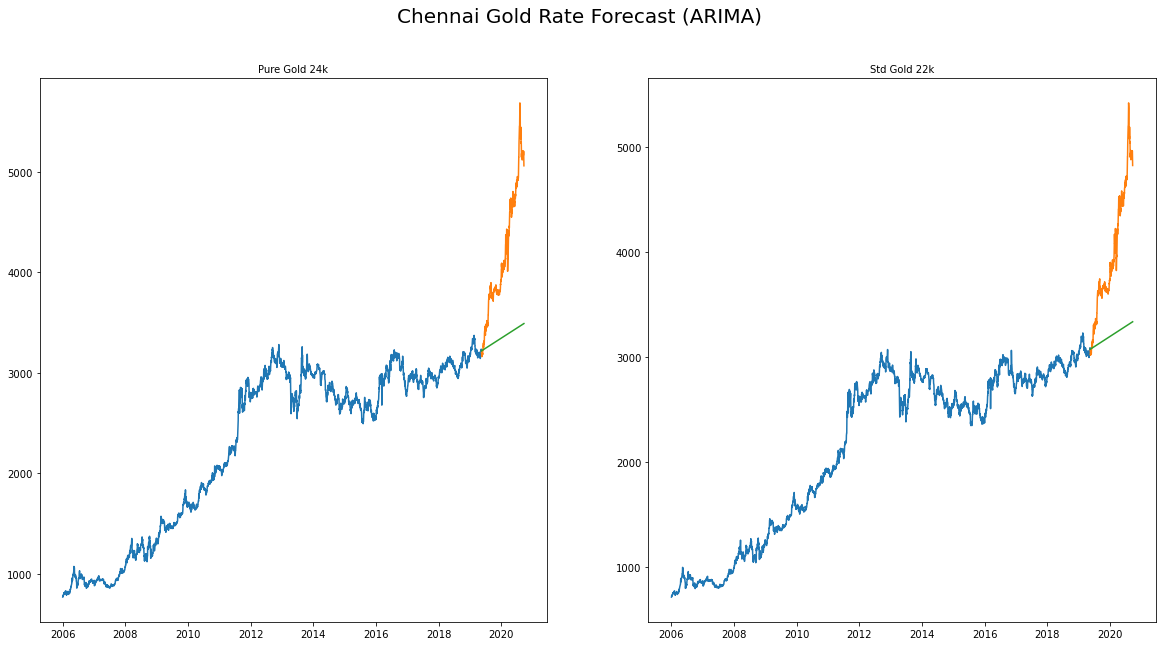

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Chennai Gold Rate Forecast (ARIMA)', fontsize=20)

ax1.plot(train_df['Pure_Gold_24k'])
ax1.plot(val_df['Pure_Gold_24k'])
ax1.plot(forecast['Forecast24k'])
ax1.set_title("Pure Gold 24k", fontsize=10)

ax2.plot(train_df['Std_Gold_22k'])
ax2.plot(val_df['Std_Gold_22k'])
ax2.plot(forecast['Forecast22k'])
ax2.set_title("Std Gold 22k", fontsize=10)

As we saw earlier, an auto ARIMA model uses past data to understand the pattern in the time series. Using these values, the model captured an increasing trend in the series. Although the predictions using this technique are far better than that of the previously implemented machine learning models, these predictions are still not close to the real values.

As its evident from the plot, the model has captured a trend in the series, but does not focus on the seasonal part.

In [18]:
# Free Memory
gc.collect()

1522

## Prophet

There are a number of time series techniques that can be implemented on the price prediction dataset, but most of these techniques require a lot of data preprocessing before fitting the model. Prophet, designed and pioneered by Facebook, is a time series forecasting library that requires no data preprocessing and is extremely simple to implement. The input for Prophet is a dataframe with two columns: date and target (ds and y).

Prophet tries to capture the seasonality in the past data and works well when the dataset is large. Here is an interesting article that explains Prophet in a simple and intuitive manner

In [19]:
df_pr.head()

NameError: name 'df_pr' is not defined

In [20]:
# Creating a copy
df_pr = df.copy()

# Converting Date Index to Column for Feature Extraction
df_pr.reset_index(level=0, inplace=True)

# Splitting the dataframe into two
df_pr_24k = df_pr[['Date','Pure_Gold_24k']]
df_pr_22k = df_pr[['Date','Std_Gold_22k']]

# Renaming Columns
df_pr_24k.rename(columns={'Date':'ds','Pure_Gold_24k':'y'},inplace=True)
df_pr_22k.rename(columns={'Date':'ds','Std_Gold_22k':'y'},inplace=True)

In [21]:
'''Pure Gold 24k dataset'''

# Split
tr_pct = int(0.9 * len(df_pr))  # 90% for training

train_df_24k = df_pr_24k[:tr_pct]
val_df_24k = df_pr_24k[tr_pct:]

'''Std Gold 22k dataset'''

# Split

train_df_22k = df_pr_22k[:tr_pct]
val_df_22k = df_pr_22k[tr_pct:]

In [22]:
# Instantiating Model
proph = Prophet()

In [23]:
'''Forecasting'''

# Pure Gold 24k
proph.fit(train_df_24k)

gold24k_price = proph.make_future_dataframe(periods=len(val_df_24k))
forecast24 = proph.predict(gold24k_price)


In [24]:
# Re-Instantiating Model
proph = Prophet()

In [25]:
'''Forecasting'''

# Std Gold 22k
proph.fit(train_df_22k)

gold22k_price = proph.make_future_dataframe(periods=len(val_df_22k))
forecast22 = proph.predict(gold22k_price)

In [26]:
# Adding Predictions to the Validation Dataset
val_df_24k['Predictions'] = 0
val_df_24k['Predictions'] = forecast24['yhat']

val_df_22k['Predictions'] = 0
val_df_22k['Predictions'] = forecast22['yhat']

Text(0.5, 1.0, 'Std Gold 22k')

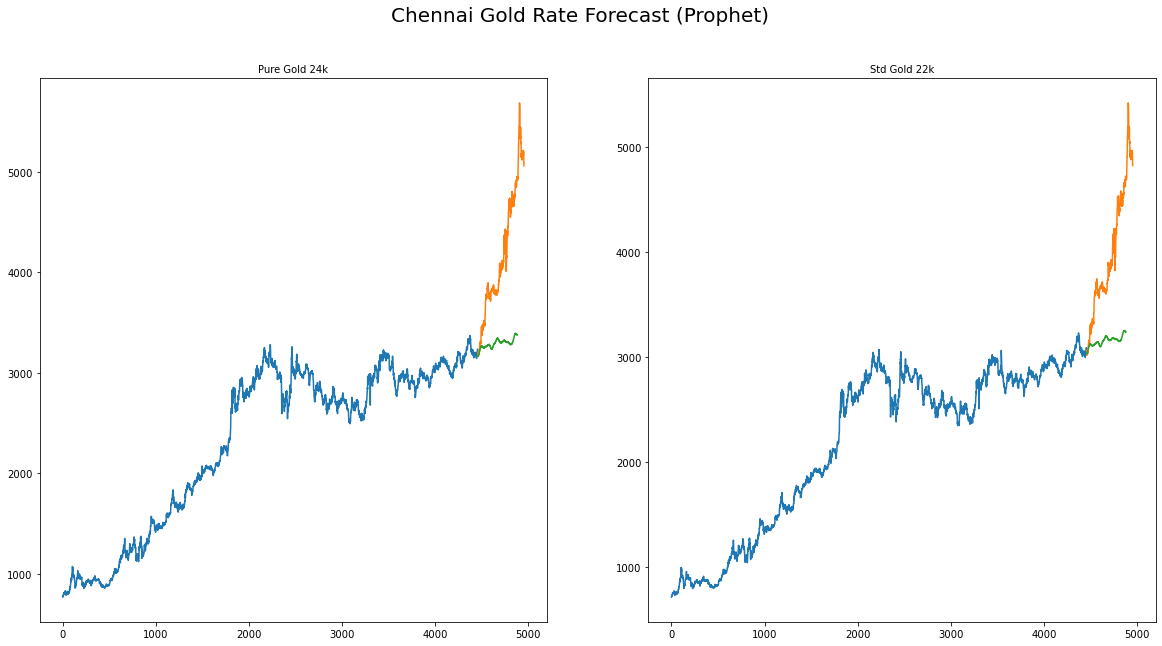

In [27]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Chennai Gold Rate Forecast (Prophet)', fontsize=20)

ax1.plot(train_df_24k['y'])
ax1.plot(val_df_24k[['y', 'Predictions']])
ax1.set_title("Pure Gold 24k", fontsize=10)

ax2.plot(train_df_22k['y'])
ax2.plot(val_df_22k[['y', 'Predictions']])
ax2.set_title("Std Gold 22k", fontsize=10)

In [28]:
# Free Memory
gc.collect()

241

### I hope this technical analysis on the Chennai Gold Rate has given you some insights and helped you understand the regression modelling & forecasting (ARIMA & Prophet). Please do consider to UPVOTE.